In [38]:
# Imports de utilidades de Python
import numpy as np
import matplotlib.pyplot as plt

# Imports de Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

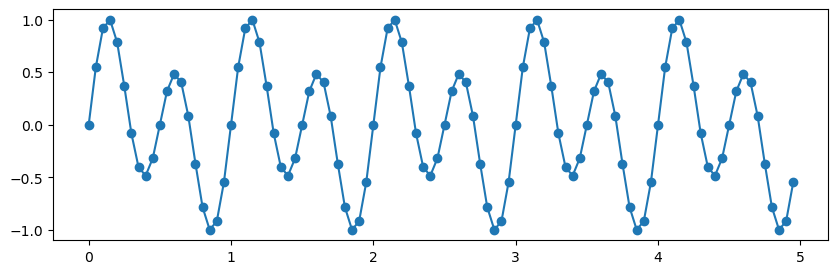

In [39]:
#Paso temporal
dt = 0.05

#Vector de tiempos
t = np.arange(0,40,dt)

# Generamos la señal temporal
raw_seq = np.sin(2*np.pi * 2 * t) + 0.5 * np.sin(2*np.pi * t)
# Maximo de la señal para normalizar
maximo = np.max(np.abs(raw_seq))
# Normalizamos
raw_seq = raw_seq/maximo

plt.figure(figsize=(10,3))
plt.plot(t[0:100], raw_seq[0:100],'-o')
plt.show()

Definimos la funcion `split_sequence` que toma como entrada la serie temporal y la cantidad de puntos que vamos a mirar para predecir el siguiente, llamada `look_back`. A partir de estos dos valores genera un dataset moviendo esta ventana de tamaño `look_back` a lo largo de la serie temporal.

In [40]:
def split_sequence(sequence, look_back):
    X, y = list(), list()
    # Recorremos la serie correspondiente al train y armamos el dataset
    for i in range(look_back, len(sequence)):
        X.append(sequence[i-look_back:i])
        y.append(sequence[i])
    X, y = np.array(X), np.array(y)
    return X, y

Definimos una ventana temporal de 5 valores y generamos nuestro dataset a partir de la señal temporal. Notemos que al ser una señal de un único valor (es una señal escalar), entonces la cantidad de features por cada paso temporal `n_features` es igual a 1. (en el caso general, podríamos aplicar la misma mecánica a series multivariadas).

In [41]:
# choose a number of time steps
look_back = 5

# Cantidad de valores por cada paso temporal
n_features = 1

# split into samples
X, y = split_sequence(raw_seq, look_back)

print(X)
# Le damos la forma adecuada a los datos para entrar a la red recurrente
# reshape from [samples, timesteps] into [samples, look_back, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

print(X)

[[ 0.          0.54758993  0.9183987   1.          0.78440613]
 [ 0.54758993  0.9183987   1.          0.78440613  0.36884989]
 [ 0.9183987   1.          0.78440613  0.36884989 -0.08281196]
 ...
 [ 0.48478965  0.40318835  0.08281196 -0.36884989 -0.78440613]
 [ 0.40318835  0.08281196 -0.36884989 -0.78440613 -1.        ]
 [ 0.08281196 -0.36884989 -0.78440613 -1.         -0.9183987 ]]
[[[ 0.        ]
  [ 0.54758993]
  [ 0.9183987 ]
  [ 1.        ]
  [ 0.78440613]]

 [[ 0.54758993]
  [ 0.9183987 ]
  [ 1.        ]
  [ 0.78440613]
  [ 0.36884989]]

 [[ 0.9183987 ]
  [ 1.        ]
  [ 0.78440613]
  [ 0.36884989]
  [-0.08281196]]

 ...

 [[ 0.48478965]
  [ 0.40318835]
  [ 0.08281196]
  [-0.36884989]
  [-0.78440613]]

 [[ 0.40318835]
  [ 0.08281196]
  [-0.36884989]
  [-0.78440613]
  [-1.        ]]

 [[ 0.08281196]
  [-0.36884989]
  [-0.78440613]
  [-1.        ]
  [-0.9183987 ]]]


In [51]:
print(y)
len(y)

[ 3.68849885e-01 -8.28119589e-02 -4.03188349e-01 -4.84789651e-01
 -3.19628163e-01 -1.35513249e-16  3.19628163e-01  4.84789651e-01
  4.03188349e-01  8.28119589e-02 -3.68849885e-01 -7.84406133e-01
 -1.00000000e+00 -9.18398697e-01 -5.47589929e-01 -4.51710832e-16
  5.47589929e-01  9.18398697e-01  1.00000000e+00  7.84406133e-01
  3.68849885e-01 -8.28119589e-02 -4.03188349e-01 -4.84789651e-01
 -3.19628163e-01 -4.06539748e-16  3.19628163e-01  4.84789651e-01
  4.03188349e-01  8.28119589e-02 -3.68849885e-01 -7.84406133e-01
 -1.00000000e+00 -9.18398697e-01 -5.47589929e-01 -9.03421663e-16
  5.47589929e-01  9.18398697e-01  1.00000000e+00  7.84406133e-01
  3.68849885e-01 -8.28119589e-02 -4.03188349e-01 -4.84789651e-01
 -3.19628163e-01 -6.77566247e-16  3.19628163e-01  4.84789651e-01
  4.03188349e-01  8.28119589e-02 -3.68849885e-01 -7.84406133e-01
 -1.00000000e+00 -9.18398697e-01 -5.47589929e-01 -1.35513249e-15
  5.47589929e-01  9.18398697e-01  1.00000000e+00  7.84406133e-01
  3.68849885e-01 -8.28119

795

Como entiendo yo $y$ y $X$?
$y$: es un array que tiene todos los valores de la secuencia excepto los primeros 'look_back' valores. 
$X$: Es un array donde cada elemento es un array de 'look_back' elementos. 

ejemplo: i = 10
y[10] = sequence[10+5] = sequence[15]
X[10] = [sequence[10],sequence[11],sequence[12],sequence[13],sequence[14],sequence[15]] 


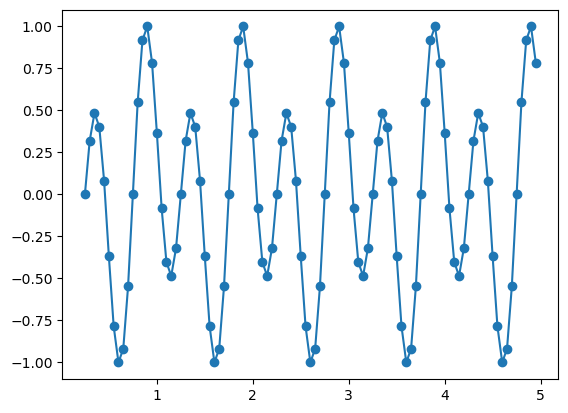

In [43]:
plt.plot(t[look_back:100], y[look_back:100],'-o')

Por último separamos la señal en train y test:

In [44]:
# Proporcion entre train y test
proporcion = 0.75

# Indice de separacion entre train y test
indice_test = int(proporcion * X.shape[0])

X_train = X[:indice_test]
y_train = y[:indice_test]
X_test = X[indice_test:]
y_test = y[indice_test:]

In [53]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

596 199
596 199


In [45]:
# Definimos el modelo Secuencial
model = Sequential()

# Agregamos la capa Recurrente (Puede ser LSTM o RNN)
model.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, n_features)))
# model.add(LSTM(20, activation='tanh', input_shape=(look_back, n_features)))

# Agregamos la capa de salida (lee el hidden Space de la recurrente)
model.add(Dense(1,activation='linear'))

# Compilamos el modelo
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=200, verbose=0,validation_data=(X_test, y_test))

In [48]:
def prediccion_pasos_adelante(model,vec_actual,pasos_adelante):

    # Preparamos una lista vacia que vamos a ir llenando con los valores predichos
    lista_valores = []
    # Recorremos n pasos hacia adelante
    for i in range(pasos_adelante):

        # Predecimos el paso siguiente
        # (El if determina si la estamos usando para la red recurrente o la densa)
        if len(vec_actual.shape)>1:
            # Prediccion Red Recurrente
            nuevo_valor = model.predict(vec_actual.reshape((1, vec_actual.shape[0], vec_actual.shape[1])))
        else:
            # Prediccion Red Densa
            nuevo_valor = model.predict(vec_actual.reshape(1, vec_actual.shape[0]))

        # Lo agregamos a la lista
        lista_valores.append(nuevo_valor[0][0])

        # Actualizmaos el vector actual con este paso
        vec_actual = np.roll(vec_actual, -1)
        vec_actual[-1] = nuevo_valor[0][0]

    lista_valores = np.asarray(lista_valores)

    return lista_valores

Calculemos con nuestro modelo entrenado una predicción de 100 pasos adelante y comparemosla con la señal real.

In [49]:
# Cantidad de pasos que queremos predecir hacia adelante
pasos_adelante = 100
indice_inicial = 0

# Tomamos un valor inicial del test set
vec_actual = X_test[indice_inicial]

# Calculamos la prediccion del modelo
predicciones_adelante = prediccion_pasos_adelante(model,vec_actual,pasos_adelante)

# Tomamos los valores esperados
valores_reales = y_test[indice_inicial:indice_inicial+pasos_adelante]

# Calculamos el error
diferencia = np.abs(predicciones_adelante-valores_reales)

1/1 [==============================] - 0s 34ms/step


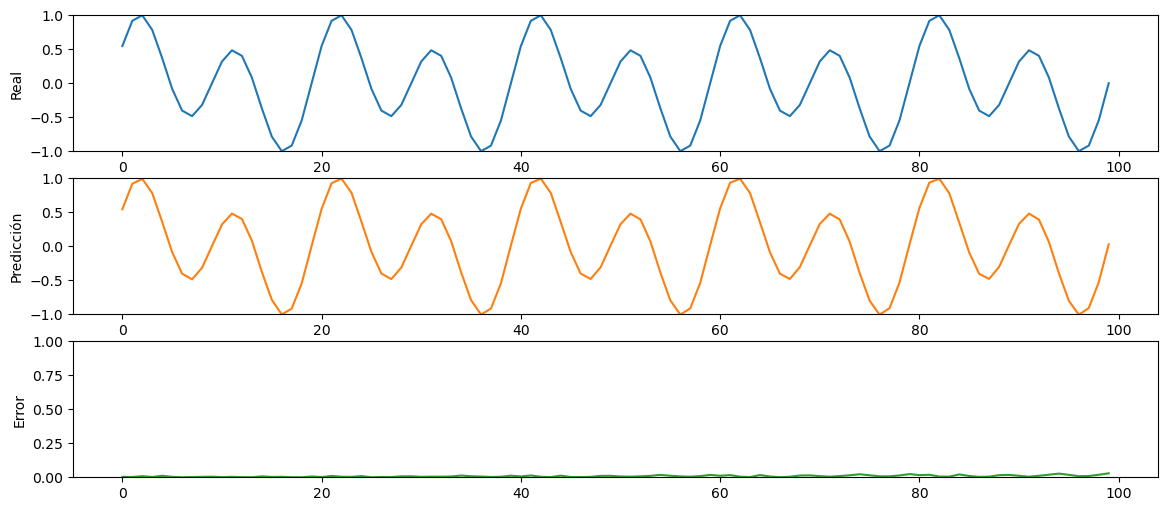

In [50]:
fig = plt.figure(figsize = (14,6))
plt.subplot(3,1,1)
plt.plot(valores_reales)
plt.ylabel('Real')
plt.ylim(-1,1)
plt.subplot(3,1,2)
plt.plot(predicciones_adelante,c='C1')
plt.ylabel('Predicción')
plt.ylim(-1,1)
plt.subplot(3,1,3)
plt.plot(diferencia,c='C2')
plt.ylabel('Error')
plt.ylim(0,1)
plt.show()